In [1]:
import EOSutils as meos

import numpy as np
import matplotlib.pyplot as plt

import matplotlib.style
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.style.use('classic')

from astropy.table import Table
from astropy import units as u
from astropy.constants import G

import mesa_helper as mh
import os
import shutil

from scipy import ndimage, interpolate, optimize

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
'''
# using ndimage

a = np.arange(12.).reshape((4, 3))
print(a)
coords = np.array(((0.5,2,1.5),(0.5,1,1.5)))
print(coords)
#linear interpolation
x = ndimage.map_coordinates(input=a, coordinates=coords, order=1)
# x[0] is a[0.5,0.5]
# x[1] is a[2, 1]
# x[2] is a[1.5,1.5]
print(x)

#cubic spline interpolation
x = ndimage.map_coordinates(input=a, coordinates=coords, order=3)
print(x)
'''

'\n# using ndimage\n\na = np.arange(12.).reshape((4, 3))\nprint(a)\ncoords = np.array(((0.5,2,1.5),(0.5,1,1.5)))\nprint(coords)\n#linear interpolation\nx = ndimage.map_coordinates(input=a, coordinates=coords, order=1)\n# x[0] is a[0.5,0.5]\n# x[1] is a[2, 1]\n# x[2] is a[1.5,1.5]\nprint(x)\n\n#cubic spline interpolation\nx = ndimage.map_coordinates(input=a, coordinates=coords, order=3)\nprint(x)\n'

In [3]:
'''
# using RegularGridInterpolator to evaluate a function on the points of a 3D grid

def f(x, y, z):
    return 2 * x**3 + 3 * y**2 - z
x = np.linspace(1, 4, 11)
y = np.linspace(4, 7, 22)
z = np.linspace(7, 9, 33)
xg, yg ,zg = np.meshgrid(x, y, z, indexing='ij', sparse=True)
data = f(xg, yg, zg)

#data is now a 3-D array with data[i, j, k] = f(x[i], y[j], z[k]).

# Next, define an interpolating function from this data:

interp = interpolate.RegularGridInterpolator((x, y, z), data, method='cubic')

print(type(interp))
print(type(interpolate.RegularGridInterpolator))

#Evaluate the interpolating function at the two points (x,y,z) = (2.1, 6.2, 8.3) and (3.3, 5.2, 7.1):
pts = np.array([[2.1, 6.2, 8.3],
                [3.3, 5.2, 7.1]])
print(interp(pts))
#which is indeed a close approximation to
print(f(2.1, 6.2, 8.3), f(3.3, 5.2, 7.1))



# using RegularGridInterpolator to interpolate and extrapolate a 2D data set

x, y = np.array([-2, 0, 4]), np.array([-2, 0, 2, 5])
def ff(x, y):
    return x**2 + y**2

xg, yg = np.meshgrid(x, y, indexing='ij')
data = ff(xg, yg)
interp = interpolate.RegularGridInterpolator((x, y), data, bounds_error=False, fill_value=None, method='linear')

#Evaluate and plot the interpolator on a finer grid
xx = np.linspace(-4, 9, 31)
yy = np.linspace(-4, 9, 31)
X, Y = np.meshgrid(xx, yy, indexing='ij')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xg.ravel(), yg.ravel(), data.ravel(),
           s=60, c='k', label='data')
# interpolator
ax.plot_wireframe(X, Y, interp((X, Y)), rstride=3, cstride=3,
                  alpha=0.4, color='m', label='linear interp')
# ground truth
ax.plot_wireframe(X, Y, ff(X, Y), rstride=3, cstride=3,
                  alpha=0.4, label='ground truth')
plt.legend()
plt.show()
'''

"\n# using RegularGridInterpolator to evaluate a function on the points of a 3D grid\n\ndef f(x, y, z):\n    return 2 * x**3 + 3 * y**2 - z\nx = np.linspace(1, 4, 11)\ny = np.linspace(4, 7, 22)\nz = np.linspace(7, 9, 33)\nxg, yg ,zg = np.meshgrid(x, y, z, indexing='ij', sparse=True)\ndata = f(xg, yg, zg)\n\n#data is now a 3-D array with data[i, j, k] = f(x[i], y[j], z[k]).\n\n# Next, define an interpolating function from this data:\n\ninterp = interpolate.RegularGridInterpolator((x, y, z), data, method='cubic')\n\nprint(type(interp))\nprint(type(interpolate.RegularGridInterpolator))\n\n#Evaluate the interpolating function at the two points (x,y,z) = (2.1, 6.2, 8.3) and (3.3, 5.2, 7.1):\npts = np.array([[2.1, 6.2, 8.3],\n                [3.3, 5.2, 7.1]])\nprint(interp(pts))\n#which is indeed a close approximation to\nprint(f(2.1, 6.2, 8.3), f(3.3, 5.2, 7.1))\n\n\n\n# using RegularGridInterpolator to interpolate and extrapolate a 2D data set\n\nx, y = np.array([-2, 0, 4]), np.array([-2, 

# Interpolate Mazevet 2020 table rho, S values to see if I can reproduce CEPAM version of the Mazevet 2020 table.

# use cgs units because CEPAM does

In [4]:
maz_orig = np.genfromtxt("./CEPAM/mazevet2020/H-Table-Tristan-Yamila.dat", skip_header=10)
# columns are
# [:,0] = T [K] 
# [:,1] = rho [g cm^-3]
# [:,2] = P [GPa] 
# [:,3] = E [eV amu^-1]
# [:,4] = S [MJ kg^-1 K^-1]

# convert P to erg cm^-3
maz_orig[:,2] = maz_orig[:,2] * 1.e10
# convert energy to erg g^-1
maz_orig[:,3] = maz_orig[:,3] * 1.6022e-12 * (1./(1.66054e-24))
# convert entropy to erg g^-1 K^-1
maz_orig[:,4] = maz_orig[:,4] * 1.e10

# swap order of columns to match CEPAM table format
maz_orig.T[[0,1,2,3,4]] = maz_orig.T[[2,0,1,4,3]]
print(np.shape(maz_orig))
      
maz_cepam = np.genfromtxt("./CEPAM/mazevet2020/Mazevet2020-H.csv",skip_header=1,delimiter=',')
# columns are
# [:,0] = log10P [erg cm^-3]
# [:,1] = log10T [K]
# [:,2] = log10rho [g cm-3]
# [:,3] = log10S [erg g^-1 K^-1]
print(np.shape(maz_cepam))

(29029, 5)
(4031, 4)


In [92]:
cms19_he_orig = np.genfromtxt("./2021_chabrier+_tables/TABLE_HE_TP_v1")
# (first few) columns are
# [:,0] = log10T [K]
# [:,1] = log10P [GPa]
# [:,2] = log10rho [g cm^-3]
# [:,3] = log10U [MJ kg^-1]
# [:,4] = log10S [MJ kg^-1 K^-1]

# convert P to erg cm^-3
cms19_he_orig[:,1] = cms19_he_orig[:,1] + 10

# convert energy to erg g^-1
cms19_he_orig[:,3] = cms19_he_orig[:,3] + 10

# convert entropy to erg g^-1 K^-1
cms19_he_orig[:,4] = cms19_he_orig[:,4] + 10

# swap order of columns to match CEPAM table format
cms19_he_orig.T[[0,1,2,3,4]] = cms19_he_orig.T[[1,0,2,4,3]]

# sort by P (column 0) and then T (column 1)
cms19_he_orig = cms19_he_orig[np.lexsort((cms19_he_orig[:,1],cms19_he_orig[:,0]))]

print(np.shape(cms19_he_orig))

cms19_he_cepam = np.genfromtxt("./CEPAM/CMS19/Chabrier2019-He.csv",skip_header=1,delimiter=',')
# columns are
# [:,0] = log10P [erg cm^-3]
# [:,1] = log10T [K]
# [:,2] = log10rho [g cm-3]
# [:,3] = log10S [erg g^-1 K^-1]
print(np.shape(cms19_he_cepam))

(53361, 10)
(53361, 4)


In [100]:
np.all(cms19_he_orig[:,0:4] == cms19_he_cepam)

True

In [5]:
print(np.min(maz_orig[:,3]))
print(np.max(maz_orig[:,3]))

print(np.min(10**maz_cepam[:,3]))
print(np.max(10**maz_cepam[:,3]))


-98054588.73
4430294923.0
961339.4840880242
4481844970.787188


# put in grid form

In [6]:
maz_orig_T = np.unique(maz_orig[:,1])
maz_orig_rho = np.unique(maz_orig[:,2])
nT = len(maz_orig_T)
nrho = len(maz_orig_rho)

maz_orig_Tgrid, maz_orig_rhogrid = np.meshgrid(maz_orig_T, maz_orig_rho)
maz_orig_Pgrid = np.zeros_like(maz_orig_Tgrid)
maz_orig_Sgrid = np.zeros_like(maz_orig_Tgrid)
maz_orig_Ugrid = np.zeros_like(maz_orig_Tgrid)

for i in range(nT):
    maz_orig_Pgrid[:,i] = maz_orig[:,0][i*nrho : (i+1)*nrho]
    maz_orig_Sgrid[:,i] = maz_orig[:,3][i*nrho : (i+1)*nrho]                
    maz_orig_Ugrid[:,i] = maz_orig[:,4][i*nrho : (i+1)*nrho]

maz_orig_log10Sgrid = np.log10(maz_orig_Sgrid)
maz_orig_log10Sgrid[np.isnan(np.log10(maz_orig_Sgrid))] = np.min(maz_orig_log10Sgrid[~np.isnan(maz_orig_log10Sgrid)])
print(np.min(maz_orig_log10Sgrid))
print(np.max(maz_orig_log10Sgrid))

maz_orig_log10Tgrid = np.log10(maz_orig_Tgrid)
maz_orig_log10rhogrid = np.log10(maz_orig_rhogrid)
maz_orig_log10Pgrid = np.log10(maz_orig_Pgrid)
maz_orig_log10Ugrid = np.log10(maz_orig_Ugrid)

5.99150096741235
9.646432637999178


/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80866/3792123707.py:16: RuntimeWarning: invalid value encountered in log10
  maz_orig_log10Sgrid = np.log10(maz_orig_Sgrid)
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80866/3792123707.py:17: RuntimeWarning: invalid value encountered in log10
  maz_orig_log10Sgrid[np.isnan(np.log10(maz_orig_Sgrid))] = np.min(maz_orig_log10Sgrid[~np.isnan(maz_orig_log10Sgrid)])


In [7]:
maz_cepam_log10T = np.unique(maz_cepam[:,1])
maz_cepam_log10P = np.unique(maz_cepam[:,0])
nlog10T = len(maz_cepam_log10T)
nlog10P = len(maz_cepam_log10P)

maz_cepam_log10Tgrid, maz_cepam_log10Pgrid = np.meshgrid(maz_cepam_log10T, maz_cepam_log10P)
maz_cepam_log10rhogrid = np.zeros_like(maz_cepam_log10Tgrid)
maz_cepam_log10Sgrid = np.zeros_like(maz_cepam_log10Tgrid)
for i in range(nlog10T):
    maz_cepam_log10rhogrid[:,i] = maz_cepam[:,2][i*nlog10P : (i+1)*nlog10P]
    maz_cepam_log10Sgrid[:,i] = maz_cepam[:,3][i*nlog10P : (i+1)*nlog10P]                

maz_cepam_Tgrid = 10**maz_cepam_log10Tgrid
maz_cepam_Pgrid = 10**maz_cepam_log10Pgrid
maz_cepam_rhogrid = 10**maz_cepam_log10rhogrid
maz_cepam_Sgrid = 10**maz_cepam_log10Sgrid

# first goal: reproduce CEPAM rho, S grids

In [8]:
# we have: 
# in maz_orig, grid of regular (rho, T) values, each with calculated P, S, U
# in maz_cepam, grid of regular (log10P, log10T) values, each with calculated rho, S

# we want:
# to find the rho value associated with a particular choice of P in maz_orig
# then, run that procedure for the full array of chosen P values from maz_cepam.

print(np.shape(maz_orig_Pgrid))

maz_orig_interp_P_given_rho_T = interpolate.RegularGridInterpolator(points=(maz_orig_rho, maz_orig_T), values=maz_orig_Pgrid, bounds_error=False, fill_value=None, method='cubic')
print(type(maz_orig_interp_P_given_rho_T))
print("")
# note that when maz_orig_interp_P_given_rho_T is created, it takes 
# points = (1D rho array, 1D T array))

# but when maz_orig_interp_P_given_rho_T is called, it requires as argument:
# 2D meshgrid P array = maz_orig_interp_P_given_rho_T((2D meshgrid rho array, 2D meshgrid T array))
# or for a single value:
# P_interpolated = maz_orig_interp_P_given_rho_T((rho_value, T_value))

print(np.shape(maz_cepam_rhogrid))

trial_P = maz_orig_interp_P_given_rho_T((maz_cepam_rhogrid, maz_cepam_Tgrid))
print(type(trial_P))
print(np.shape(trial_P))
print("")

trial_P2 = maz_orig_interp_P_given_rho_T((1.39847031e-06, 205))
print(type(trial_P2))
print(np.shape(trial_P2))
print(trial_P2)

(1001, 29)
<class 'scipy.interpolate._rgi.RegularGridInterpolator'>

(139, 29)
<class 'numpy.ndarray'>
(139, 29)

<class 'numpy.ndarray'>
()
11826.996379460996


In [49]:
# construct an interpolator to get P as a function of (rho, T)
interp_P_given_rho_T_cubic = interpolate.RegularGridInterpolator(points=(maz_orig_rho, maz_orig_T), values=maz_orig_Pgrid, bounds_error=False, fill_value=None, method='cubic')
interp_log10P_given_log10rho_log10T_cubic = interpolate.RegularGridInterpolator(points=(np.log10(maz_orig_rho), np.log10(maz_orig_T)), values=maz_orig_log10Pgrid, bounds_error=False, fill_value=None, method='cubic')

interp_P_given_rho_T_linear = interpolate.RegularGridInterpolator(points=(maz_orig_rho, maz_orig_T), values=maz_orig_Pgrid, bounds_error=False, fill_value=None, method='linear')
interp_log10P_given_log10rho_log10T_linear = interpolate.RegularGridInterpolator(points=(np.log10(maz_orig_rho), np.log10(maz_orig_T)), values=maz_orig_log10Pgrid, bounds_error=False, fill_value=None, method='linear')

def interp_P(rho, T, method='cubic'):
    if method == 'cubic':
        return interp_P_given_rho_T_cubic((rho,T))
    elif method == 'linear':
        return interp_P_given_rho_T_linear((rho,T))

def interp_log10P(log10rho, log10T, method='cubic'):
    if method == 'cubic':
        return interp_log10P_given_log10rho_log10T_cubic((log10rho,log10T))
    elif method == 'linear':
        return interp_log10P_given_log10rho_log10T_linear((log10rho,log10T))
        
def P_abs_diff(rho, P, T, method='cubic'):
        return np.abs(P - interp_P(rho,T,method))
def log10P_abs_diff(log10rho, log10P, log10T, method='cubic'):
        return np.abs(log10P - interp_log10P(log10rho,log10T,method))




# construct interpolators to get S and U as functions of (rho,T)
interp_S_given_rho_T_cubic = interpolate.RegularGridInterpolator(points=(maz_orig_rho, maz_orig_T), values=maz_orig_Sgrid, bounds_error=False, fill_value=None, method='cubic')
interp_log10S_given_log10rho_log10T_cubic = interpolate.RegularGridInterpolator(points=(np.log10(maz_orig_rho), np.log10(maz_orig_T)), values=maz_orig_log10Sgrid, bounds_error=False, fill_value=None, method='cubic')

interp_S_given_rho_T_linear = interpolate.RegularGridInterpolator(points=(maz_orig_rho, maz_orig_T), values=maz_orig_Sgrid, bounds_error=False, fill_value=None, method='linear')
interp_log10S_given_log10rho_log10T_linear = interpolate.RegularGridInterpolator(points=(np.log10(maz_orig_rho), np.log10(maz_orig_T)), values=maz_orig_log10Sgrid, bounds_error=False, fill_value=None, method='linear')

interp_U_given_rho_T_cubic = interpolate.RegularGridInterpolator(points=(maz_orig_rho, maz_orig_T), values=maz_orig_Ugrid, bounds_error=False, fill_value=None, method='cubic')
interp_log10U_given_log10rho_log10T_cubic = interpolate.RegularGridInterpolator(points=(np.log10(maz_orig_rho), np.log10(maz_orig_T)), values=maz_orig_log10Ugrid, bounds_error=False, fill_value=None, method='cubic')

interp_U_given_rho_T_linear = interpolate.RegularGridInterpolator(points=(maz_orig_rho, maz_orig_T), values=maz_orig_Ugrid, bounds_error=False, fill_value=None, method='linear')
interp_log10U_given_log10rho_log10T_linear = interpolate.RegularGridInterpolator(points=(np.log10(maz_orig_rho), np.log10(maz_orig_T)), values=maz_orig_log10Ugrid, bounds_error=False, fill_value=None, method='linear')


def interp_S(rho, T, method='cubic'):
    if method == 'cubic':
        return interp_S_given_rho_T_cubic((rho,T))
    elif method == 'linear':
        return interp_S_given_rho_T_linear((rho,T))

def interp_log10S(log10rho, log10T, method='cubic'):
    if method == 'cubic':
        return interp_log10S_given_log10rho_log10T_cubic((log10rho,log10T))
    elif method == 'linear':
        return interp_log10S_given_log10rho_log10T_linear((log10rho,log10T))
      
def interp_U(rho, T, method='cubic'):
    if method == 'cubic':
        return interp_U_given_rho_T_cubic((rho,T))
    elif method == 'linear':
        return interp_U_given_rho_T_linear((rho,T))

def interp_log10U(log10rho, log10T, method='cubic'):
    if method == 'cubic':
        return interp_log10U_given_log10rho_log10T_cubic((log10rho,log10T))
    elif method == 'linear':
        return interp_log10U_given_log10rho_log10T_linear((log10rho,log10T))


# given an input P and T, solve for the best rho, then calculate the corresponding S and U
def solve_rhoSU(P, T, rho0=1.e-5, method='cubic'):
    opt = optimize.minimize(P_abs_diff, x0=rho0, args=(P,T,method),bounds=[(7.e-10,9)], tol=1.e-15) #lower and upper bounds on rho come from np.min, max of maz_cepam_rhogrid
    opt_rho = opt.x[0]

    corresponding_S = interp_S(opt_rho, T, method)
    corresponding_U = interp_U(opt_rho, T, method)
    return opt_rho, corresponding_S, corresponding_U

def solve_log10rhoSU(log10P, log10T, log10rho0=-5., method='cubic'):
    opt = optimize.minimize(log10P_abs_diff, x0=log10rho0, args=(log10P,log10T,method),bounds=[(-9.,1.)], tol=1.e-10) #lower and upper bounds on rho come from np.min, max of np.log10(maz_cepam_rhogrid)
    opt_log10rho = opt.x[0]

    corresponding_log10S = interp_log10S(opt_log10rho, log10T, method)
    corresponding_log10U = interp_log10U(opt_log10rho, log10T, method)
    return opt_log10rho, corresponding_log10S, corresponding_log10U



In [61]:
# reproduce Yamila's interpolation (hopefully)
print(np.shape(maz_cepam_log10Tgrid))
#print(maz_cepam_log10Tgrid)
#print(maz_cepam_log10Pgrid)

maz_cepam_log10rhogrid_interpolated = np.zeros_like(maz_cepam_log10Tgrid)
maz_cepam_log10Sgrid_interpolated = np.zeros_like(maz_cepam_log10Tgrid)
maz_cepam_log10Ugrid_interpolated = np.zeros_like(maz_cepam_log10Tgrid)

for i in range(np.shape(maz_cepam_log10Tgrid)[1]):
    this_log10T = maz_cepam_log10Tgrid[0][i]
    for j in range(np.shape(maz_cepam_log10Pgrid)[0]):
        this_log10P = maz_cepam_log10Pgrid[:,0][j]

        # try cubic interpolation first
        interpolated_log10rho, interpolated_log10S, interpolated_log10U  = solve_log10rhoSU(log10P=this_log10P, log10T=this_log10T, log10rho0=-5, method='cubic')

        # calculate the relative difference wrt Yamila's interpolation
        log10rho_reldiff = np.log10(np.abs((maz_cepam_log10rhogrid[j,i] - interpolated_log10rho)/maz_cepam_log10rhogrid[j,i]))
        # if it's too great, switch to linear interpolation just for this point
        if log10rho_reldiff > -1:
            interpolated_log10rho, interpolated_log10S, interpolated_log10U  = solve_log10rhoSU(log10P=this_log10P, log10T=this_log10T, log10rho0=-5, method='linear')
        
        maz_cepam_log10rhogrid_interpolated[j,i] = interpolated_log10rho
        maz_cepam_log10Sgrid_interpolated[j,i] = interpolated_log10S
        maz_cepam_log10Ugrid_interpolated[j,i] = interpolated_log10U


(139, 29)


In [71]:
print(np.min(maz_orig_log10Ugrid))
print(np.max(maz_orig_log10Ugrid))

9.775565461736177
13.58785939120076


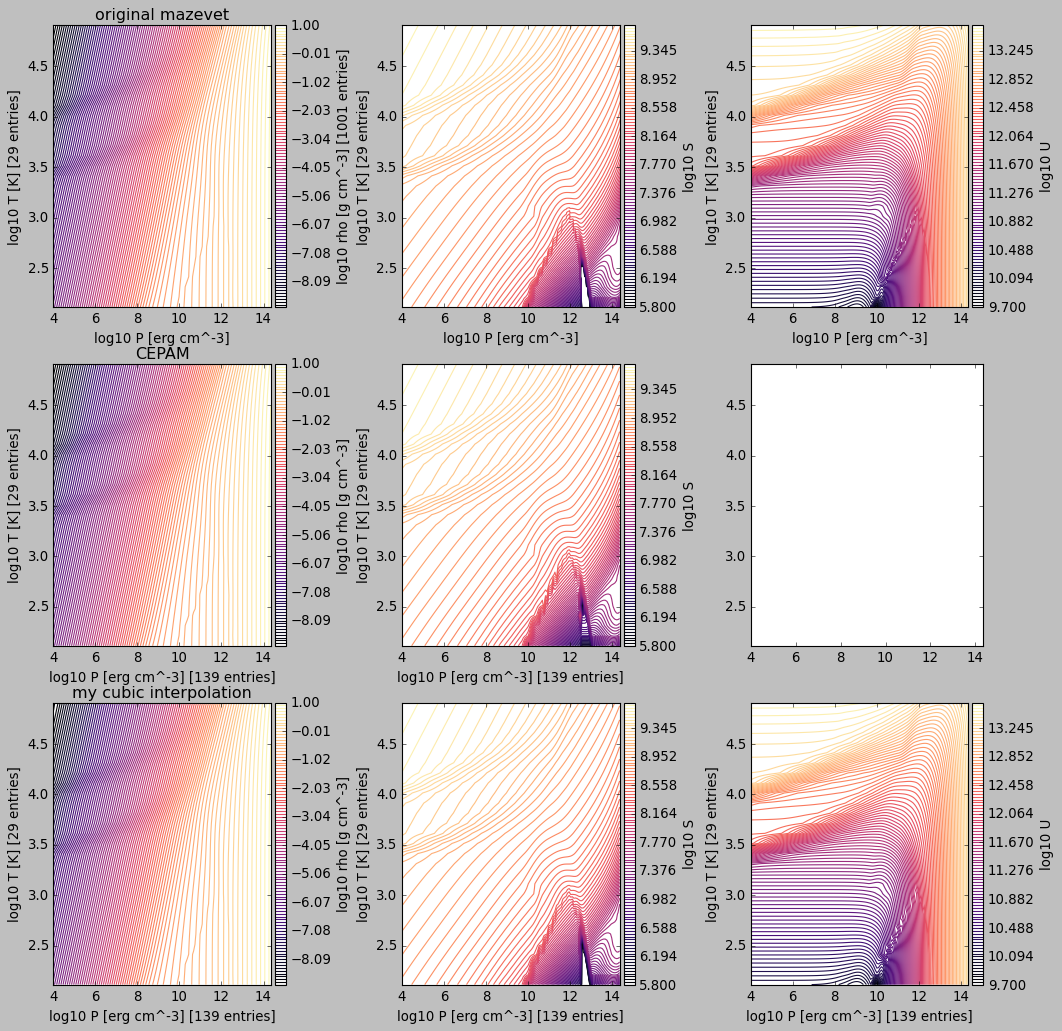

In [77]:
log10rholevels = np.linspace(-9.,1.,100)
log10rhovmin = -9.
log10rhovmax = 1.

log10Slevels = np.linspace(5.8,9.7,100)
log10Svmin = 5.8
log10Svmax = 9.7

log10Ulevels = np.linspace(9.7,13.6,100)
log10Uvmin = 9.7
log10Uvmax = 13.6


fig, axes = plt.subplots(3,3,figsize=(15,15))

# row 0: original Mazevet
divider00 = make_axes_locatable(axes[0,0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0,0].contour(maz_orig_log10Pgrid, maz_orig_log10Tgrid, maz_orig_log10rhogrid, levels=log10rholevels, cmap='magma',alpha=1,vmin=log10rhovmin, vmax=log10rhovmax)
fig.colorbar(cs00, cax=cax00, orientation='vertical',label='log10 rho [g cm^-3] [{0} entries]'.format(np.shape(maz_orig_log10Tgrid)[0]))
axes[0,0].set_ylabel('log10 T [K] [{0} entries]'.format(np.shape(maz_orig_log10Tgrid)[1]))
axes[0,0].set_xlabel('log10 P [erg cm^-3]')

divider01 = make_axes_locatable(axes[0,1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[0,1].contour(maz_orig_log10Pgrid, maz_orig_log10Tgrid, maz_orig_log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
fig.colorbar(cs01, cax=cax01, orientation='vertical',label='log10 S')
axes[0,1].set_ylabel('log10 T [K] [{0} entries]'.format(np.shape(maz_orig_log10Tgrid)[1]))
axes[0,1].set_xlabel('log10 P [erg cm^-3]')

divider02 = make_axes_locatable(axes[0,2])
cax02 = divider02.append_axes('right', size='5%', pad=0.05)
cs02 = axes[0,2].contour(maz_orig_log10Pgrid, maz_orig_log10Tgrid, maz_orig_log10Ugrid, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
fig.colorbar(cs02, cax=cax02, orientation='vertical',label='log10 U')
axes[0,2].set_ylabel('log10 T [K] [{0} entries]'.format(np.shape(maz_orig_log10Tgrid)[1]))
axes[0,2].set_xlabel('log10 P [erg cm^-3]')

# row 1: CEPAM interpolated
divider10 = make_axes_locatable(axes[1,0])
cax10 = divider10.append_axes('right', size='5%', pad=0.05)
cs10 = axes[1,0].contour(maz_cepam_log10Pgrid, maz_cepam_log10Tgrid, maz_cepam_log10rhogrid, levels=log10rholevels, cmap='magma',alpha=1,vmin=log10rhovmin, vmax=log10rhovmax)
fig.colorbar(cs10, cax=cax10, orientation='vertical',label='log10 rho [g cm^-3]')
axes[1,0].set_ylabel('log10 T [K] [{0} entries]'.format(np.shape(maz_cepam_log10Tgrid)[1]))
axes[1,0].set_xlabel('log10 P [erg cm^-3] [{0} entries]'.format(np.shape(maz_cepam_log10Tgrid)[0]))

divider11 = make_axes_locatable(axes[1,1])
cax11 = divider11.append_axes('right', size='5%', pad=0.05)
cs11 = axes[1,1].contour(maz_cepam_log10Pgrid, maz_cepam_log10Tgrid, maz_cepam_log10Sgrid, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
fig.colorbar(cs11, cax=cax11, orientation='vertical',label='log10 S')
axes[1,1].set_ylabel('log10 T [K] [{0} entries]'.format(np.shape(maz_cepam_log10Tgrid)[1]))
axes[1,1].set_xlabel('log10 P [erg cm^-3] [{0} entries]'.format(np.shape(maz_cepam_log10Tgrid)[0]))

# row 2: my interpolated
divider20 = make_axes_locatable(axes[2,0])
cax20 = divider20.append_axes('right', size='5%', pad=0.05)
cs20 = axes[2,0].contour(maz_cepam_log10Pgrid, maz_cepam_log10Tgrid, maz_cepam_log10rhogrid_interpolated, levels=log10rholevels, cmap='magma',alpha=1,vmin=log10rhovmin, vmax=log10rhovmax)
fig.colorbar(cs20, cax=cax20, orientation='vertical',label='log10 rho [g cm^-3]')
axes[2,0].set_ylabel('log10 T [K] [{0} entries]'.format(np.shape(maz_cepam_log10Tgrid)[1]))
axes[2,0].set_xlabel('log10 P [erg cm^-3] [{0} entries]'.format(np.shape(maz_cepam_log10Tgrid)[0]))

divider21 = make_axes_locatable(axes[2,1])
cax21 = divider21.append_axes('right', size='5%', pad=0.05)
cs21 = axes[2,1].contour(maz_cepam_log10Pgrid, maz_cepam_log10Tgrid, maz_cepam_log10Sgrid_interpolated, levels=log10Slevels, cmap='magma',alpha=1,vmin=log10Svmin, vmax=log10Svmax)
fig.colorbar(cs21, cax=cax21, orientation='vertical',label='log10 S')
axes[2,1].set_ylabel('log10 T [K] [{0} entries]'.format(np.shape(maz_cepam_log10Tgrid)[1]))
axes[2,1].set_xlabel('log10 P [erg cm^-3] [{0} entries]'.format(np.shape(maz_cepam_log10Tgrid)[0]))

divider22 = make_axes_locatable(axes[2,2])
cax22 = divider22.append_axes('right', size='5%', pad=0.05)
cs22 = axes[2,2].contour(maz_cepam_log10Pgrid, maz_cepam_log10Tgrid, maz_cepam_log10Ugrid_interpolated, levels=log10Ulevels, cmap='magma',alpha=1,vmin=log10Uvmin, vmax=log10Uvmax)
fig.colorbar(cs22, cax=cax22, orientation='vertical',label='log10 U')
axes[2,2].set_ylabel('log10 T [K] [{0} entries]'.format(np.shape(maz_cepam_log10Tgrid)[1]))
axes[2,2].set_xlabel('log10 P [erg cm^-3] [{0} entries]'.format(np.shape(maz_cepam_log10Tgrid)[0]))

for ax in np.ravel(axes):
    ax.set_xlim(4.,14.35)
    ax.set_ylim(2.11,4.91)

axes[0,0].set_title("original mazevet")
axes[1,0].set_title("CEPAM")
axes[2,0].set_title("my cubic interpolation")
plt.subplots_adjust(wspace=0.5)
#plt.show()
plt.savefig("mazevet2022_vs_cubic_interpolation.pdf",bbox_inches='tight')

-9.24368665211418
0.3889106973754014

-9.378266307157935
-0.9147452817171541


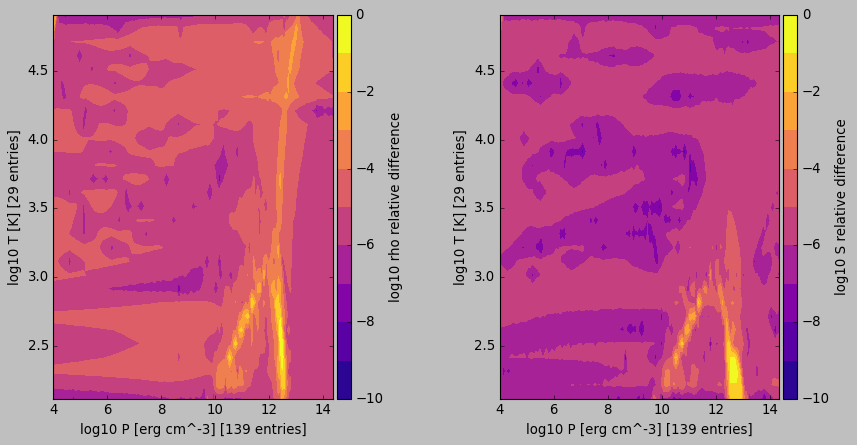

In [83]:
#fractional differences between my interpolation and CEPAM's
diffvmin = -10
diffvmax = -0.5
difflevels = np.linspace(diffvmin,0,11)

log10rho_reldiff = np.log10(np.abs((maz_cepam_log10rhogrid - maz_cepam_log10rhogrid_interpolated)/maz_cepam_log10rhogrid))
log10S_reldiff = np.log10(np.abs((maz_cepam_log10Sgrid - maz_cepam_log10Sgrid_interpolated)/maz_cepam_log10Sgrid))
print(np.min(log10rho_reldiff))
print(np.max(log10rho_reldiff))
print("")
print(np.min(log10S_reldiff))
print(np.max(log10S_reldiff))


fig, axes = plt.subplots(1,2,figsize=(12,6))

divider0 = make_axes_locatable(axes[0])
cax0 = divider0.append_axes('right', size='5%', pad=0.05)
cs0 = axes[0].contourf(maz_cepam_log10Pgrid, maz_cepam_log10Tgrid, log10rho_reldiff, levels=difflevels, cmap='plasma',alpha=1,vmin=diffvmin, vmax=diffvmax)
fig.colorbar(cs0, cax=cax0, orientation='vertical',label='log10 rho relative difference')
axes[0].set_ylabel('log10 T [K] [{0} entries]'.format(np.shape(maz_cepam_log10Tgrid)[1]))
axes[0].set_xlabel('log10 P [erg cm^-3] [{0} entries]'.format(np.shape(maz_cepam_log10Tgrid)[0]))

divider1 = make_axes_locatable(axes[1])
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cs1 = axes[1].contourf(maz_cepam_log10Pgrid, maz_cepam_log10Tgrid, log10S_reldiff, levels=difflevels, cmap='plasma',alpha=1,vmin=diffvmin, vmax=diffvmax)
fig.colorbar(cs1, cax=cax1, orientation='vertical',label='log10 S relative difference')
axes[1].set_ylabel('log10 T [K] [{0} entries]'.format(np.shape(maz_cepam_log10Tgrid)[1]))
axes[1].set_xlabel('log10 P [erg cm^-3] [{0} entries]'.format(np.shape(maz_cepam_log10Tgrid)[0]))


for ax in axes:
    ax.set_xlim(4.,14.35)
    ax.set_ylim(2.11,4.91)

plt.subplots_adjust(wspace=0.5)
#plt.show()
plt.savefig("mazevet2022_rel_diff_btwn_CEPAM_interpolation_and_mine.pdf",bbox_inches='tight')

In [74]:
#what is up with the handful of points with larger relative differences?
print(maz_cepam_log10Pgrid[log10rho_reldiff > -0.5])
print(maz_cepam_log10Tgrid[log10rho_reldiff > -0.5])

print(maz_cepam_log10Pgrid[log10S_reldiff > -0.95])
print(maz_cepam_log10Tgrid[log10S_reldiff > -0.95])


[12.3999786 12.4749784]
[2.61394739 2.41396999]
[12.5499783 12.6249781 12.6999779 12.7749777]
[2.31386733 2.31386733 2.31386733 2.31386733]


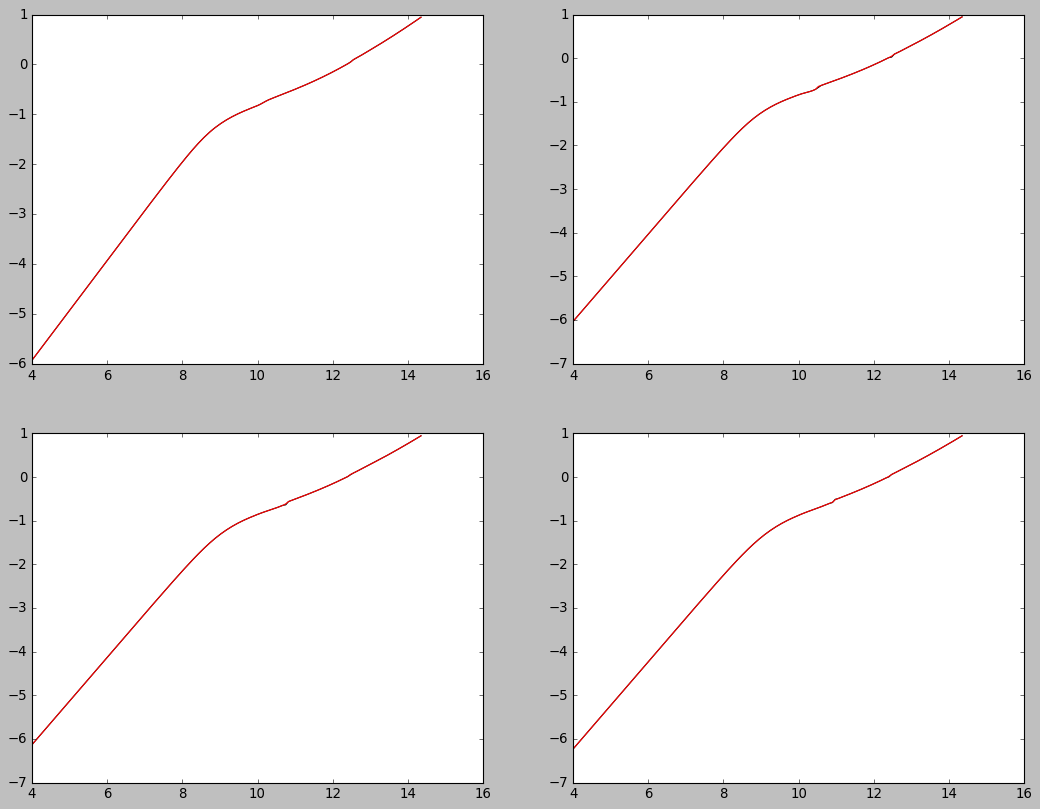

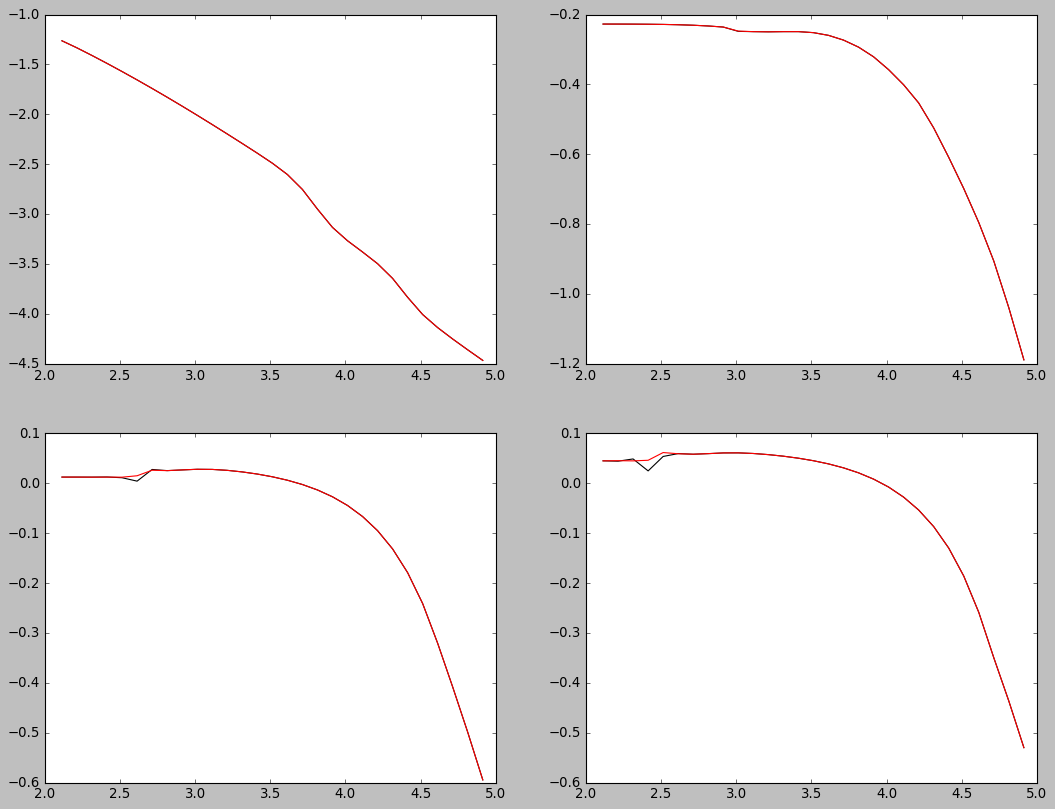

"\nfig, axes = plt.subplots(2,2,figsize=(16,12))\n\n# log10P = 12.4749784\naxes[0,0].plot(maz_cepam_log10Tgrid[113], maz_cepam_log10Sgrid[113], 'k-')\naxes[0,0].plot(maz_cepam_log10Tgrid[113], maz_cepam_log10Sgrid_interpolated[113], 'r-')\n#axes[0,0].set_xlim(12,13)\n#axes[0,0].set_ylim(-0.3,0.5)\n\n# log10P = 12.5499783\naxes[0,1].plot(maz_cepam_log10Tgrid[114], maz_cepam_log10Sgrid[114], 'k-')\naxes[0,1].plot(maz_cepam_log10Tgrid[114], maz_cepam_log10Sgrid_interpolated[114], 'r-')\n\n# log10P = 12.6249781\naxes[1,0].plot(maz_cepam_log10Tgrid[115], maz_cepam_log10Sgrid[115], 'k-')\naxes[1,0].plot(maz_cepam_log10Tgrid[115], maz_cepam_log10Sgrid_interpolated[115], 'r-')\n\n# log10P = 12.6999779\naxes[1,1].plot(maz_cepam_log10Tgrid[116], maz_cepam_log10Sgrid[116], 'k-')\naxes[1,1].plot(maz_cepam_log10Tgrid[116], maz_cepam_log10Sgrid_interpolated[116], 'r-')\n\n#ax.set_xlim(6,14)\n#ax.set_ylim(-3,0.5)\n\nax.set_xlabel('log10T')\nax.set_ylabel('log10S')\nplt.show()\n"

In [75]:
fig, axes = plt.subplots(2,2,figsize=(16,12))

# T = 2.31386733
axes[0,0].plot(maz_cepam_log10Pgrid[:,2], maz_cepam_log10rhogrid[:,2], 'k-')
axes[0,0].plot(maz_cepam_log10Pgrid[:,2], maz_cepam_log10rhogrid_interpolated[:,2], 'r-')
#axes[0,0].set_xlim(12,13)
#axes[0,0].set_ylim(-0.3,0.5)

# T = 2.41396999
axes[0,1].plot(maz_cepam_log10Pgrid[:,3], maz_cepam_log10rhogrid[:,3], 'k-')
axes[0,1].plot(maz_cepam_log10Pgrid[:,3], maz_cepam_log10rhogrid_interpolated[:,3], 'r-')

# T = 2.51388311
axes[1,0].plot(maz_cepam_log10Pgrid[:,4], maz_cepam_log10rhogrid[:,4], 'k-')
axes[1,0].plot(maz_cepam_log10Pgrid[:,4], maz_cepam_log10rhogrid_interpolated[:,4], 'r-')

# T = 2.61394739
axes[1,1].plot(maz_cepam_log10Pgrid[:,5], maz_cepam_log10rhogrid[:,5], 'k-')
axes[1,1].plot(maz_cepam_log10Pgrid[:,5], maz_cepam_log10rhogrid_interpolated[:,5], 'r-')

ax.set_xlim(6,14)
ax.set_ylim(-3,0.5)

ax.set_xlabel('log10P')
ax.set_ylabel('log10rho')
plt.show()

'''

fig, axes = plt.subplots(2,2,figsize=(16,12))

# log10T = 2.31386733
axes[0,0].plot(maz_cepam_log10Pgrid[:,2], maz_cepam_log10Sgrid[:,2], 'k-')
axes[0,0].plot(maz_cepam_log10Pgrid[:,2], maz_cepam_log10Sgrid_interpolated[:,2], 'r-')
#axes[0,0].set_xlim(12,13)
#axes[0,0].set_ylim(-0.3,0.5)

# log10T = 2.41396999
axes[0,1].plot(maz_cepam_log10Pgrid[:,3], maz_cepam_log10Sgrid[:,3], 'k-')
axes[0,1].plot(maz_cepam_log10Pgrid[:,3], maz_cepam_log10Sgrid_interpolated[:,3], 'r-')

# log10T = 2.51388311
axes[1,0].plot(maz_cepam_log10Pgrid[:,4], maz_cepam_log10Sgrid[:,4], 'k-')
axes[1,0].plot(maz_cepam_log10Pgrid[:,4], maz_cepam_log10Sgrid_interpolated[:,4], 'r-')

# log10T = 2.61394739
axes[1,1].plot(maz_cepam_log10Pgrid[:,5], maz_cepam_log10Sgrid[:,5], 'k-')
axes[1,1].plot(maz_cepam_log10Pgrid[:,5], maz_cepam_log10Sgrid_interpolated[:,5], 'r-')

#ax.set_xlim(6,14)
#ax.set_ylim(-3,0.5)

ax.set_xlabel('log10P')
ax.set_ylabel('log10S')
plt.show()
'''

fig, axes = plt.subplots(2,2,figsize=(16,12))

# log10P = 8.64998817 
axes[0,0].plot(maz_cepam_log10Tgrid[62], maz_cepam_log10rhogrid[62], 'k-')
axes[0,0].plot(maz_cepam_log10Tgrid[62], maz_cepam_log10rhogrid_interpolated[62], 'r-')
#axes[0,0].set_xlim(12,13)
#axes[0,0].set_ylim(-0.3,0.5)

# log10P = 11.7999802
axes[0,1].plot(maz_cepam_log10Tgrid[104], maz_cepam_log10rhogrid[104], 'k-')
axes[0,1].plot(maz_cepam_log10Tgrid[104], maz_cepam_log10rhogrid_interpolated[104], 'r-')

# log10P = 12.3999786
axes[1,0].plot(maz_cepam_log10Tgrid[112], maz_cepam_log10rhogrid[112], 'k-')
axes[1,0].plot(maz_cepam_log10Tgrid[112], maz_cepam_log10rhogrid_interpolated[112], 'r-')

# log10P = 12.4749784
axes[1,1].plot(maz_cepam_log10Tgrid[113], maz_cepam_log10rhogrid[113], 'k-')
axes[1,1].plot(maz_cepam_log10Tgrid[113], maz_cepam_log10rhogrid_interpolated[113], 'r-')

#ax.set_xlim(6,14)
#ax.set_ylim(-3,0.5)

ax.set_xlabel('log10T')
ax.set_ylabel('log10rho')
plt.show()
'''
fig, axes = plt.subplots(2,2,figsize=(16,12))

# log10P = 12.4749784
axes[0,0].plot(maz_cepam_log10Tgrid[113], maz_cepam_log10Sgrid[113], 'k-')
axes[0,0].plot(maz_cepam_log10Tgrid[113], maz_cepam_log10Sgrid_interpolated[113], 'r-')
#axes[0,0].set_xlim(12,13)
#axes[0,0].set_ylim(-0.3,0.5)

# log10P = 12.5499783
axes[0,1].plot(maz_cepam_log10Tgrid[114], maz_cepam_log10Sgrid[114], 'k-')
axes[0,1].plot(maz_cepam_log10Tgrid[114], maz_cepam_log10Sgrid_interpolated[114], 'r-')

# log10P = 12.6249781
axes[1,0].plot(maz_cepam_log10Tgrid[115], maz_cepam_log10Sgrid[115], 'k-')
axes[1,0].plot(maz_cepam_log10Tgrid[115], maz_cepam_log10Sgrid_interpolated[115], 'r-')

# log10P = 12.6999779
axes[1,1].plot(maz_cepam_log10Tgrid[116], maz_cepam_log10Sgrid[116], 'k-')
axes[1,1].plot(maz_cepam_log10Tgrid[116], maz_cepam_log10Sgrid_interpolated[116], 'r-')

#ax.set_xlim(6,14)
#ax.set_ylim(-3,0.5)

ax.set_xlabel('log10T')
ax.set_ylabel('log10S')
plt.show()
'''